# LSTM for song detection trained on spectral features

In [24]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import random
import librosa

### Setup

In [25]:
# Set random seeds for reproducibility
random_seed = 42
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(random_seed)

# Device configuration
DEVICE = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
print(f"Using device: {DEVICE}")

# Constants
SAMPLE_RATE = 44100  # Adjust as needed
SEGMENT_LENGTH = 5000  # Max sequence length
OVERLAP = 0  # No overlap

# Data directories (Replace with your actual paths)
train_directory = "/Users/benburress-irving/Downloads/gardnerlab_rotationproject/labeled_song_dataset/train"  
validation_directory = "/Users/benburress-irving/Downloads/gardnerlab_rotationproject/labeled_song_dataset/test"  

# Combine labeled files from both directories
all_files = [os.path.join(train_directory, f) for f in os.listdir(train_directory) if f.endswith(".npz")]
all_files += [os.path.join(validation_directory, f) for f in os.listdir(validation_directory) if f.endswith(".npz")]
print(f"Total number of labeled files: {len(all_files)}")

# Shuffle files and split into 80% train and 20% validation
random.shuffle(all_files)
split_index = int(0.8 * len(all_files))
train_files = all_files[:split_index]
validation_files = all_files[split_index:]

print(f"Number of training files: {len(train_files)}")
print(f"Number of validation files: {len(validation_files)}")

Using device: mps
Total number of labeled files: 368
Number of training files: 294
Number of validation files: 74


### Apply min-max normalization

In [26]:
def min_max_normalize(feature, axis=0):
    return (feature - np.min(feature, axis=axis, keepdims=True)) / (np.ptp(feature, axis=axis, keepdims=True) + 1e-6)


### Load and process data from spectrograms

In [27]:
def load_and_process_data(files, directory):
    features_list = []
    labels_list = []
    for filename in files:
        file_path = os.path.join(directory, filename)
        f = np.load(file_path, allow_pickle=True)
        
        s = f['s']  # Spectrogram data (complex numbers)
        labels = f['song']  # Labels

        # Convert labels to float32 and replace 2.0 with 0.0
        labels = np.array(labels).astype(np.float32)
        labels[labels == 2.0] = 0.0

        # Convert spectrogram to magnitude for feature calculations
        magnitude_spectrogram = np.abs(s)  # Shape: [freq_bins, time_frames]

        # Compute spectral features over entire frequency range (no frequency bins)
        spectral_rolloff = librosa.feature.spectral_rolloff(S=magnitude_spectrogram, sr=SAMPLE_RATE)[0]
        spectral_flatness = librosa.feature.spectral_flatness(S=magnitude_spectrogram)[0]
        spectral_bandwidth = librosa.feature.spectral_bandwidth(S=magnitude_spectrogram, sr=SAMPLE_RATE)[0]
        spectral_contrast = librosa.feature.spectral_contrast(S=magnitude_spectrogram, sr=SAMPLE_RATE).mean(axis=0)

        # Normalize spectral features
        spectral_rolloff = min_max_normalize(spectral_rolloff)
        spectral_flatness = min_max_normalize(spectral_flatness)
        spectral_bandwidth = min_max_normalize(spectral_bandwidth)
        spectral_contrast = min_max_normalize(spectral_contrast)

        # Stack features along the last axis
        spectral_features = np.stack([
            spectral_rolloff,
            spectral_flatness,
            spectral_bandwidth,
            spectral_contrast
        ], axis=-1)  # Shape: [time_frames, features]

        # Ensure labels and features match in time frames
        min_length = min(labels.shape[0], spectral_features.shape[0])
        labels = labels[:min_length]
        spectral_features = spectral_features[:min_length, :]

        features_list.append(spectral_features)  # Shape per sample: [time_frames, features]
        labels_list.append(labels)
        
    return features_list, labels_list



NameError: name 'features_list' is not defined

### Padding sequences for NumPy alignment

In [28]:
def pad_sequences(features_list, labels_list, max_seq_len):
    batch_size = len(features_list)
    num_features = features_list[0].shape[1]  # Number of spectral features

    # Initialize padded arrays
    padded_features = np.zeros((batch_size, max_seq_len, num_features), dtype=np.float32)
    padded_labels = np.full((batch_size, max_seq_len), -1, dtype=np.float32)  # -1 for padding

    for i, (features, labels) in enumerate(zip(features_list, labels_list)):
        seq_len = features.shape[0]
        if seq_len > max_seq_len:
            # Truncate if longer than max_seq_len
            features = features[:max_seq_len, :]
            labels = labels[:max_seq_len]
            seq_len = max_seq_len
        padded_features[i, :seq_len, :] = features
        padded_labels[i, :seq_len] = labels

    return padded_features, padded_labels

### Data processing

In [29]:
print(f"Number of training files: {len(train_files)}")
print(f"Number of validation files: {len(validation_files)}")

# Load and process data
train_features_list, train_labels_list = load_and_process_data(train_files, train_directory)
validation_features_list, validation_labels_list = load_and_process_data(validation_files, validation_directory)

# Determine maximum sequence length
max_seq_len_train = max(f.shape[0] for f in train_features_list)
max_seq_len_val = max(f.shape[0] for f in validation_features_list)
max_seq_len = min(max(max_seq_len_train, max_seq_len_val), SEGMENT_LENGTH)

print(f"Max sequence length: {max_seq_len}")

# Pad sequences
padded_train_features, padded_train_labels = pad_sequences(train_features_list, train_labels_list, max_seq_len)
padded_validation_features, padded_validation_labels = pad_sequences(validation_features_list, validation_labels_list, max_seq_len)

# Convert to PyTorch tensors
train_input_tensor = torch.tensor(padded_train_features, dtype=torch.float32)
train_target_tensor = torch.tensor(padded_train_labels, dtype=torch.float32)

validation_input_tensor = torch.tensor(padded_validation_features, dtype=torch.float32)
validation_target_tensor = torch.tensor(padded_validation_labels, dtype=torch.float32)

# Validate dimensions
print(f"Train Input Tensor Shape: {train_input_tensor.shape}")
print(f"Train Target Tensor Shape: {train_target_tensor.shape}")
print(f"Validation Input Tensor Shape: {validation_input_tensor.shape}")
print(f"Validation Target Tensor Shape: {validation_target_tensor.shape}")

# Compute class weights for handling class imbalance
total_labels = np.concatenate(train_labels_list).flatten()
# Exclude any -1 labels (if any)
total_labels = total_labels[total_labels != -1]
num_zeros = np.sum(total_labels == 0)
num_ones = np.sum(total_labels == 1)
pos_weight = num_zeros / num_ones
print(f"Number of zeros: {num_zeros}")
print(f"Number of ones: {num_ones}")
print(f"Positive class weight (pos_weight): {pos_weight:.4f}")

pos_weight_tensor = torch.tensor(pos_weight, dtype=torch.float32)



Number of training files: 294
Number of validation files: 74
Max sequence length: 5000
Train Input Tensor Shape: torch.Size([294, 5000, 4])
Train Target Tensor Shape: torch.Size([294, 5000])
Validation Input Tensor Shape: torch.Size([74, 5000, 4])
Validation Target Tensor Shape: torch.Size([74, 5000])
Number of zeros: 1277381
Number of ones: 656871
Positive class weight (pos_weight): 1.9446


### LSTM model for song detection

In [30]:
class SongLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(SongLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=0.1  # Added dropout to help prevent overfitting
        )
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        # x shape: [batch_size, seq_len, input_size]
        x = x.to(DEVICE)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(DEVICE)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(DEVICE)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out)  # Shape: [batch_size, seq_len, 1]
        out = torch.sigmoid(out)  # Apply sigmoid to get probabilities between 0 and 1
        return out.squeeze(-1)  # Shape: [batch_size, seq_len]



### Model initialization and setup

In [75]:

# Initialize the model
input_size = train_input_tensor.shape[2]  # Number of spectral features
hidden_size = 32  
num_layers = 1    

model = SongLSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers).to(DEVICE)

# Define the loss function
criterion = nn.BCELoss(reduction='none')  # Use BCELoss since outputs are probabilities

# Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)


# Create datasets and dataloaders
train_dataset = TensorDataset(train_input_tensor, train_target_tensor)
validation_dataset = TensorDataset(validation_input_tensor, validation_target_tensor)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=16)

# Training loop
num_epochs = 20  # Increased the number of epochs
best_val_loss = float('inf')
epochs_no_improve = 0
early_stopping_patience = 10  # Increased patience



/Users/benburress-irving/Downloads/gardnerlab_rotationproject/.venv/lib/python3.8/site-packages/torch/nn/modules/rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


### Grid search

### Training the model

In [80]:
import matplotlib.pyplot as plt
from sklearn.model_selection import ParameterGrid
import copy
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

# Placeholder for best parameters and performance
best_val_loss = float('inf')
best_params = None
best_model = None

# Define a grid of hyperparameters
param_grid = {
    'hidden_size': [256],
    'learning_rate': [0.0005],
    'num_layers': [2],
    'batch_size': [32],
    'early_stopping_patience': [4]
}

# Generate all combinations of parameters
grid = ParameterGrid(param_grid)

# Loop over each parameter combination
for params in grid:
    print(f"\nTesting parameters: {params}")

    # Unpack hyperparameters
    hidden_size = params["hidden_size"]
    num_layers = params["num_layers"]
    learning_rate = params["learning_rate"]
    batch_size = params["batch_size"]
    early_stopping_patience = params["early_stopping_patience"]

    # Initialize the model with the current parameters
    model = SongLSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers).to(DEVICE)

    # Loss function and optimizer
    criterion = nn.BCELoss(reduction='none')
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Adjust batch size for dataloaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    validation_loader = DataLoader(validation_dataset, batch_size=batch_size)

    # Early stopping variables
    current_best_val_loss = float('inf')
    epochs_no_improve = 0

    # Lists to track training and validation metrics for each combination
    train_losses, train_accuracies, val_losses, val_accuracies = [], [], [], []

    # Training loop
    num_epochs = 20
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        # Training
        for batch_inputs, batch_targets in train_loader:
            batch_inputs, batch_targets = batch_inputs.to(DEVICE), batch_targets.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(batch_inputs)
            loss = criterion(outputs, batch_targets)

            # Create mask to ignore padding (where labels are -1)
            mask = (batch_targets != -1).float()
            batch_weights = torch.where(batch_targets == 1, pos_weight_tensor.to(DEVICE), torch.tensor(1.0).to(DEVICE))
            loss = (loss * batch_weights * mask).sum() / mask.sum()

            loss.backward()
            optimizer.step()
            train_loss += loss.item()

            # Compute accuracy
            with torch.no_grad():
                predictions = (outputs > 0.5).float()
                correct = ((predictions == batch_targets) * mask).sum()
                total = mask.sum()
                train_correct += correct.item()
                train_total += total.item()

        train_loss_epoch = train_loss / len(train_loader)
        train_accuracy = train_correct / train_total
        train_losses.append(train_loss_epoch)
        train_accuracies.append(train_accuracy)

        # Validation
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for val_inputs_batch, val_targets_batch in validation_loader:
                val_inputs_batch, val_targets_batch = val_inputs_batch.to(DEVICE), val_targets_batch.to(DEVICE)
                val_outputs = model(val_inputs_batch)
                val_loss_batch = criterion(val_outputs, val_targets_batch)
                
                # Apply mask
                mask = (val_targets_batch != -1).float()
                batch_weights = torch.where(val_targets_batch == 1, pos_weight_tensor.to(DEVICE), torch.tensor(1.0).to(DEVICE))
                val_loss_batch = (val_loss_batch * batch_weights * mask).sum() / mask.sum()

                val_loss += val_loss_batch.item()

                # Compute accuracy
                predictions = (val_outputs > 0.5).float()
                correct = ((predictions == val_targets_batch) * mask).sum()
                total = mask.sum()
                val_correct += correct.item()
                val_total += total.item()

        val_loss_epoch = val_loss / len(validation_loader)
        val_accuracy = val_correct / val_total
        val_losses.append(val_loss_epoch)
        val_accuracies.append(val_accuracy)

        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Train Loss: {train_loss_epoch:.4f}, Train Accuracy: {train_accuracy:.4f}, '
              f'Val Loss: {val_loss_epoch:.4f}, Val Accuracy: {val_accuracy:.4f}')

        # Check for improvement for early stopping
        if val_loss_epoch < current_best_val_loss:
            current_best_val_loss = val_loss_epoch
            epochs_no_improve = 0
            best_model_state = copy.deepcopy(model.state_dict())
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= early_stopping_patience:
            print("Early stopping!")
            break

    # Check if this is the best model so far
    if current_best_val_loss < best_val_loss:
        best_val_loss = current_best_val_loss
        best_params = params
        best_model = copy.deepcopy(model)
        # Save the best model checkpoint
        torch.save(best_model_state, "best_song_lstm_model.pth")

print(f"\nBest params: {best_params}, Best validation loss: {best_val_loss:.4f}")



Testing parameters: {'batch_size': 32, 'early_stopping_patience': 4, 'hidden_size': 256, 'learning_rate': 0.0005, 'num_layers': 2}
Epoch [1/20], Train Loss: 0.8961, Train Accuracy: 0.6660, Val Loss: 0.9794, Val Accuracy: 0.6586
Epoch [2/20], Train Loss: 0.8248, Train Accuracy: 0.6958, Val Loss: 1.0804, Val Accuracy: 0.6407
Epoch [3/20], Train Loss: 0.8319, Train Accuracy: 0.6719, Val Loss: 0.8735, Val Accuracy: 0.6804
Epoch [4/20], Train Loss: 0.7202, Train Accuracy: 0.7178, Val Loss: 0.8937, Val Accuracy: 0.7440
Epoch [5/20], Train Loss: 0.6747, Train Accuracy: 0.7184, Val Loss: 0.7864, Val Accuracy: 0.7691
Epoch [6/20], Train Loss: 0.6275, Train Accuracy: 0.7334, Val Loss: 0.7244, Val Accuracy: 0.7917
Epoch [7/20], Train Loss: 0.6224, Train Accuracy: 0.7504, Val Loss: 0.7011, Val Accuracy: 0.7633
Epoch [8/20], Train Loss: 0.6188, Train Accuracy: 0.7485, Val Loss: 0.7153, Val Accuracy: 0.7684
Epoch [9/20], Train Loss: 0.6074, Train Accuracy: 0.7441, Val Loss: 0.7723, Val Accuracy: 0.

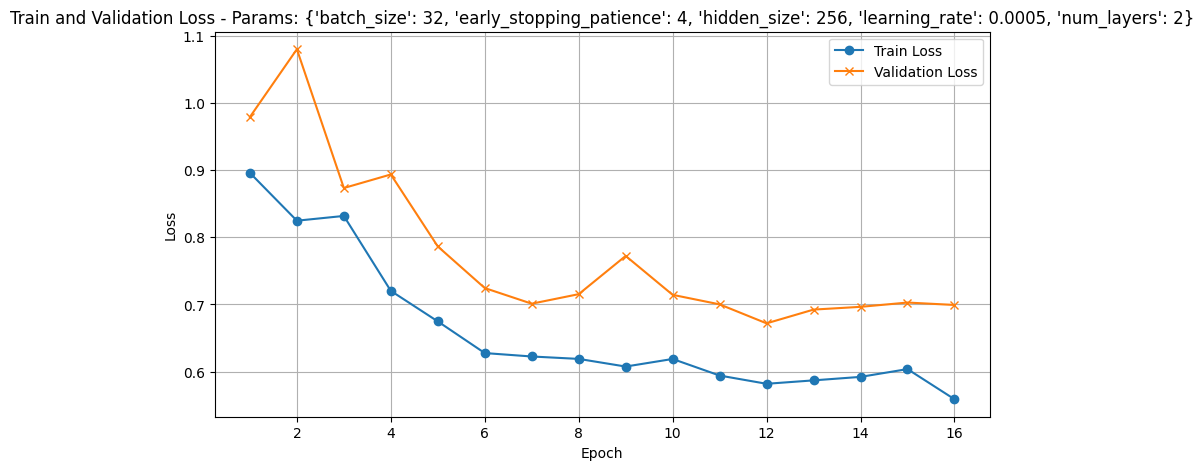

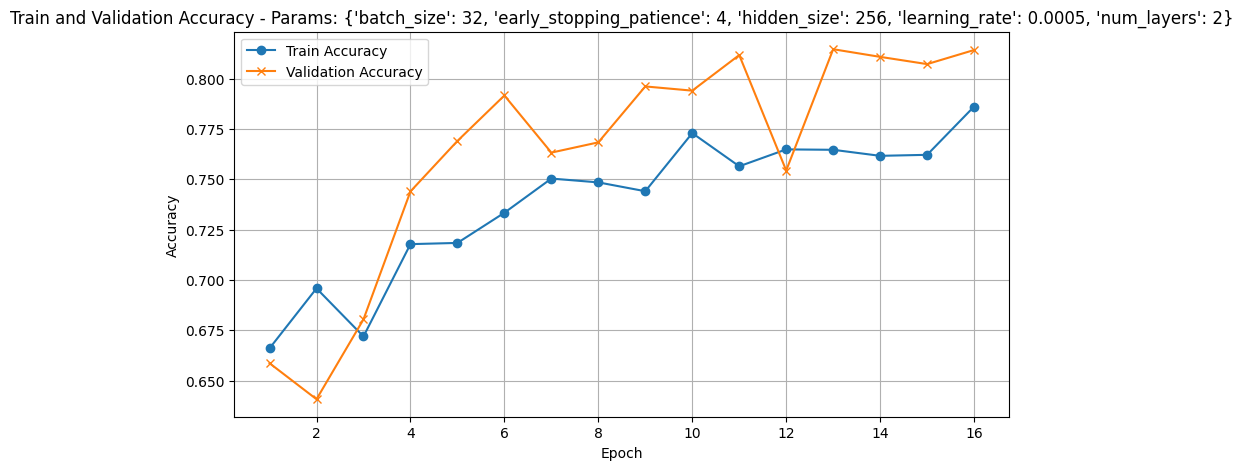

In [82]:
import matplotlib.pyplot as plt
import re

# Step 1: Read the log file
with open("loss.txt", "r") as file:
    log_text = file.read()

# Step 2: Parse the log text
# Initialize dictionaries to store metrics for each parameter combination
results = {}

# Regular expressions for capturing parameter set and each epoch's metrics
params_pattern = r"Testing parameters: ({.*?})"
epoch_pattern = r"Epoch \[(\d+)/\d+\], Train Loss: ([\d.]+), Train Accuracy: ([\d.]+), Val Loss: ([\d.]+), Val Accuracy: ([\d.]+)"

# Parse the text line by line
for param_match in re.finditer(params_pattern, log_text):
    params = eval(param_match.group(1))  # Convert string representation of dict to actual dict
    param_str = str(params)  # Use the string representation as the key

    # Initialize metrics lists for the current parameter combination
    results[param_str] = {
        'train_loss': [],
        'train_accuracy': [],
        'val_loss': [],
        'val_accuracy': []
    }

    # Find subsequent epochs for the current parameter set
    epoch_start_idx = param_match.end()
    for epoch_match in re.finditer(epoch_pattern, log_text[epoch_start_idx:]):
        # Append each metric to the relevant list
        results[param_str]['train_loss'].append(float(epoch_match.group(2)))
        results[param_str]['train_accuracy'].append(float(epoch_match.group(3)))
        results[param_str]['val_loss'].append(float(epoch_match.group(4)))
        results[param_str]['val_accuracy'].append(float(epoch_match.group(5)))

# Step 3: Plot results for each parameter combination
for param_set, metrics in results.items():
    epochs = range(1, len(metrics['train_loss']) + 1)

    # Plot Training and Validation Loss
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, metrics['train_loss'], label='Train Loss', marker='o')
    plt.plot(epochs, metrics['val_loss'], label='Validation Loss', marker='x')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Train and Validation Loss - Params: {param_set}')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot Training and Validation Accuracy
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, metrics['train_accuracy'], label='Train Accuracy', marker='o')
    plt.plot(epochs, metrics['val_accuracy'], label='Validation Accuracy', marker='x')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(f'Train and Validation Accuracy - Params: {param_set}')
    plt.legend()
    plt.grid(True)
    plt.show()


In [ ]:
import matplotlib.pyplot as plt
import re

# Sample log text
log_text = """
Testing parameters: {'batch_size': 32, 'early_stopping_patience': 4, 'hidden_size': 16, 'learning_rate': 0.0005, 'num_layers': 1}
Epoch [1/20], Train Loss: 0.8377, Train Accuracy: 0.5938, Val Loss: 0.7481, Val Accuracy: 0.8125
Epoch [2/20], Train Loss: 0.8344, Train Accuracy: 0.6314, Val Loss: 0.7501, Val Accuracy: 0.7975
...
Early stopping!
"""

# Step 1: Parse the log text
# Initialize dictionaries to store metrics for each parameter combination
results = {}

# Regular expressions for capturing parameter set and each epoch's metrics
params_pattern = r"Testing parameters: ({.*?})"
epoch_pattern = r"Epoch \[(\d+)/\d+\], Train Loss: ([\d.]+), Train Accuracy: ([\d.]+), Val Loss: ([\d.]+), Val Accuracy: ([\d.]+)"

# Parse the text line by line
for param_match in re.finditer(params_pattern, log_text):
    params = eval(param_match.group(1))  # Convert string representation of dict to actual dict
    param_str = str(params)  # Use the string representation as the key

    # Initialize metrics lists for the current parameter combination
    results[param_str] = {
        'train_loss': [],
        'train_accuracy': [],
        'val_loss': [],
        'val_accuracy': []
    }

    # Find subsequent epochs for the current parameter set
    for epoch_match in re.finditer(epoch_pattern, log_text[param_match.end():]):
        # Append each metric to the relevant list
        results[param_str]['train_loss'].append(float(epoch_match.group(2)))
        results[param_str]['train_accuracy'].append(float(epoch_match.group(3)))
        results[param_str]['val_loss'].append(float(epoch_match.group(4)))
        results[param_str]['val_accuracy'].append(float(epoch_match.group(5)))

# Step 2: Plot results for each parameter combination
for param_set, metrics in results.items():
    epochs = range(1, len(metrics['train_loss']) + 1)

    # Plot Training and Validation Loss
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, metrics['train_loss'], label='Train Loss', marker='o')
    plt.plot(epochs, metrics['val_loss'], label='Validation Loss', marker='x')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Train and Validation Loss - Params: {param_set}')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot Training and Validation Accuracy
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, metrics['train_accuracy'], label='Train Accuracy', marker='o')
    plt.plot(epochs, metrics['val_accuracy'], label='Validation Accuracy', marker='x')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(f'Train and Validation Accuracy - Params: {param_set}')
    plt.legend()
    plt.grid(True)
    plt.show()

### Plotting logits over spectrogram

In [83]:
# Load data for the first 100 samples in the validation directory
validation_files = [f for f in os.listdir(validation_directory) if f.endswith('.npz')]

# Ensure we only process the first 100 files
for sample_index in range(min(100, len(validation_files))):  # Ensure we don't exceed the number of available files
    # Load data for the selected sample
    f = np.load(os.path.join(validation_directory, validation_files[sample_index]), allow_pickle=True)
    s = f['s']           # Spectrogram data
    labels = f['song']   # Ground truth labels (0 for silence, 1 for song)

    # Check the original spectrogram data
    print(f"Original spectrogram min: {np.min(s)}, max: {np.max(s)}")

    # Convert labels
    labels = np.array(labels).astype(np.float32)
    labels[labels == 2.0] = 0.0

    # Check the spectrogram (assumed to be in dB scale already)
    print(f"Spectrogram min: {np.min(s)}, max: {np.max(s)}")

    # Get the model's predictions
    model.eval()
    with torch.no_grad():
        sample_input = validation_input_tensor[sample_index].unsqueeze(0)  # Add batch dimension
        outputs = model(sample_input)
        probabilities = outputs.squeeze(0).cpu().numpy()

    # Plot the spectrogram
    plt.figure(figsize=(14, 6))
    plt.imshow(
        s,  # Use the original spectrogram directly
        aspect='auto', 
        vmin=np.min(s),  # Set to the minimum value of s
        vmax=np.max(s)   # Set to the maximum value of s
    )
    
    # Use the filename (without extension) as the title
    file_name = os.path.basename(validation_files[sample_index]).replace('.npz', '')
    plt.title(f'Spectrogram with Binary Overlay and Predicted Probabilities - {file_name}')
    
    plt.xlabel('Time Frames')
    plt.ylabel('Frequency Bins')

    # Invert the y-axis to have 0 at the bottom
    plt.gca().invert_yaxis()

    # The time axis for the spectrogram
    time_frames = np.arange(s.shape[1])  # Adjusted to use the original shape

    # Adjust the y-axis limits to make room for the overlay bar at the bottom
    plt.ylim([0, s.shape[0]])

    # Plot the binary overlay as a bar at the bottom
    overlay_height = 10  # Height of the overlay bar in frequency bins

    # Ensure labels match the time frames
    if len(labels) != s.shape[1]:
        labels = np.interp(
            np.linspace(0, 1, s.shape[1]), 
            np.linspace(0, 1, len(labels)), 
            labels
        )
        labels = np.round(labels).astype(int)

    # Plot the blue bar for '0' (silence)
    plt.fill_between(
        time_frames, 
        0, 
        overlay_height, 
        where=labels == 0, 
        color='blue', 
        label='Silence'
    )

    # Plot the red bar for '1' (song)
    plt.fill_between(
        time_frames, 
        0, 
        overlay_height, 
        where=labels == 1, 
        color='red', 
        label='Song'
    )

    # Get the predicted probabilities for the sample
    sample_probs = probabilities

    # If sequences were padded, adjust for original length
    seq_len = s.shape[1]  # Use the original sequence length
    sample_probs = sample_probs[:seq_len]

    # Ensure sample_probs match the time frames
    if len(sample_probs) != s.shape[1]:
        sample_probs = np.interp(
            np.linspace(0, 1, s.shape[1]), 
            np.linspace(0, 1, len(sample_probs)), 
            sample_probs
        )

    # Scale sample_probs to plot over the spectrogram
    scaled_probs = overlay_height + sample_probs * (s.shape[0] - overlay_height)

    # Plot the predicted probabilities as a line
    plt.plot(
        time_frames, 
        scaled_probs, 
        color='cyan', 
        label='Predicted Probability'
    )

    # Add legend
    plt.legend(loc='upper right')

    # Save the plot
    plt.savefig(os.path.join(save_directory, f'sample_{file_name}.png'))  # Save with the filename
    plt.close()  # Close the figure to free memory

Original spectrogram min: -0.3885358225567393, max: 9.023082851951893
Spectrogram min: -0.3885358225567393, max: 9.023082851951893
Original spectrogram min: -0.48704093397270526, max: 8.12177197263532
Spectrogram min: -0.48704093397270526, max: 8.12177197263532
Original spectrogram min: -59.99999994690843, max: 28.37263689240303
Spectrogram min: -59.99999994690843, max: 28.37263689240303
Original spectrogram min: -80.0, max: 0.0
Spectrogram min: -80.0, max: 0.0
Original spectrogram min: -59.99999963352951, max: 32.368906229873524
Spectrogram min: -59.99999963352951, max: 32.368906229873524
Original spectrogram min: -0.5341207755204954, max: 10.950216807869696
Spectrogram min: -0.5341207755204954, max: 10.950216807869696
Original spectrogram min: -59.999999342970824, max: 28.437531660388654
Spectrogram min: -59.999999342970824, max: 28.437531660388654
Original spectrogram min: -59.999999993116546, max: 45.87945024974499
Spectrogram min: -59.999999993116546, max: 45.87945024974499
Origin

KeyboardInterrupt: 

### Saving spectrograms to directory

In [85]:
save_directory = "/Users/benburress-irving/Downloads/gardnerlab_rotationproject/final_predictions"  
validation_directory = "/Users/benburress-irving/Downloads/gardnerlab_rotationproject/labeled_song_dataset/test"  

# Load data for the first 100 samples in the validation directory
validation_files = [f for f in os.listdir(validation_directory) if f.endswith('.npz')]

# Ensure we only process the first 100 files
for sample_index in range(min(100, len(validation_files))):  # Ensure we don't exceed the number of available files
    # Load data for the selected sample
    f = np.load(os.path.join(validation_directory, validation_files[sample_index]), allow_pickle=True)
    s = f['s']           # Spectrogram data
    labels = f['song']   # Ground truth labels (0 for silence, 1 for song)

    # Check the original spectrogram data
    print(f"Original spectrogram min: {np.min(s)}, max: {np.max(s)}")

    # Convert labels
    labels = np.array(labels).astype(np.float32)
    labels[labels == 2.0] = 0.0

    # Check the spectrogram (assumed to be in dB scale already)
    print(f"Spectrogram min: {np.min(s)}, max: {np.max(s)}")

    # Get the model's predictions
    model.eval()
    with torch.no_grad():
        sample_input = validation_input_tensor[sample_index].unsqueeze(0)  # Add batch dimension
        outputs = model(sample_input)
        probabilities = outputs.squeeze(0).cpu().numpy()

    # Apply thresholding: set values below 0.5 to 0
    threshold = 0.5
    thresholded_probs = np.where(probabilities > threshold, probabilities, 0)

    # Plot the spectrogram
    plt.figure(figsize=(14, 6))
    plt.imshow(
        s,  # Use the original spectrogram directly
        aspect='auto', 
        vmin=np.min(s),  # Set to the minimum value of s
        vmax=np.max(s)   # Set to the maximum value of s
    )
    
    # Use the filename (without extension) as the title
    file_name = os.path.basename(validation_files[sample_index]).replace('.npz', '')
    plt.title(f'Spectrogram with Binary Overlay and Predicted Probabilities - {file_name}')
    
    plt.xlabel('Time Frames')
    plt.ylabel('Frequency Bins')

    # Invert the y-axis to have 0 at the bottom
    plt.gca().invert_yaxis()

    # The time axis for the spectrogram
    time_frames = np.arange(s.shape[1])  # Adjusted to use the original shape

    # Adjust the y-axis limits to make room for the overlay bar at the bottom
    plt.ylim([0, s.shape[0]])

    # Plot the binary overlay as a bar at the bottom
    overlay_height = 10  # Height of the overlay bar in frequency bins

    # Ensure labels match the time frames
    if len(labels) != s.shape[1]:
        labels = np.interp(
            np.linspace(0, 1, s.shape[1]), 
            np.linspace(0, 1, len(labels)), 
            labels
        )
        labels = np.round(labels).astype(int)

    # Plot the blue bar for '0' (silence)
    plt.fill_between(
        time_frames, 
        0, 
        overlay_height, 
        where=labels == 0, 
        color='blue', 
        label='Silence'
    )

    # Plot the red bar for '1' (song)
    plt.fill_between(
        time_frames, 
        0, 
        overlay_height, 
        where=labels == 1, 
        color='red', 
        label='Song'
    )

    # If sequences were padded, adjust for original length
    seq_len = s.shape[1]  # Use the original sequence length
    thresholded_probs = thresholded_probs[:seq_len]

    # Ensure thresholded_probs match the time frames
    if len(thresholded_probs) != s.shape[1]:
        thresholded_probs = np.interp(
            np.linspace(0, 1, s.shape[1]), 
            np.linspace(0, 1, len(thresholded_probs)), 
            thresholded_probs
        )

    # Scale thresholded_probs to plot over the spectrogram
    scaled_probs = overlay_height + thresholded_probs * (s.shape[0] - overlay_height)

    # Plot the predicted probabilities as a line
    plt.plot(
        time_frames, 
        scaled_probs, 
        color='cyan', 
        label='Predicted Probability'
    )

    # Add legend
    plt.legend(loc='upper right')

    # Save the plot
    plt.savefig(os.path.join(save_directory, f'sample_{file_name}.png'))  # Save with the filename
    plt.close()  # Close the figure to free memory


Original spectrogram min: -0.3885358225567393, max: 9.023082851951893
Spectrogram min: -0.3885358225567393, max: 9.023082851951893
Original spectrogram min: -0.48704093397270526, max: 8.12177197263532
Spectrogram min: -0.48704093397270526, max: 8.12177197263532
Original spectrogram min: -59.99999994690843, max: 28.37263689240303
Spectrogram min: -59.99999994690843, max: 28.37263689240303
Original spectrogram min: -80.0, max: 0.0
Spectrogram min: -80.0, max: 0.0
Original spectrogram min: -59.99999963352951, max: 32.368906229873524
Spectrogram min: -59.99999963352951, max: 32.368906229873524
Original spectrogram min: -0.5341207755204954, max: 10.950216807869696
Spectrogram min: -0.5341207755204954, max: 10.950216807869696
Original spectrogram min: -59.999999342970824, max: 28.437531660388654
Spectrogram min: -59.999999342970824, max: 28.437531660388654
Original spectrogram min: -59.999999993116546, max: 45.87945024974499
Spectrogram min: -59.999999993116546, max: 45.87945024974499
Origin

IndexError: index 74 is out of bounds for dimension 0 with size 74

In [72]:
# Load data for the first 100 samples in the validation directory
for sample_index in range(min(100, len(validation_files))):  # Ensure we don't exceed the number of available files
    # Load data for the selected sample
    f = np.load(os.path.join(validation_directory, validation_files[sample_index]), allow_pickle=True)
    s = f['s']           # Spectrogram data
    labels = f['song']   # Ground truth labels (0 for silence, 1 for song)

    # Check the original spectrogram data
    print(f"Original spectrogram min: {np.min(s)}, max: {np.max(s)}")

    # Convert labels
    labels = np.array(labels).astype(np.float32)
    labels[labels == 2.0] = 0.0

    # Check the spectrogram (assumed to be in dB scale already)
    print(f"Spectrogram min: {np.min(s)}, max: {np.max(s)}")

    # Get the model's predictions
    model.eval()
    with torch.no_grad():
        sample_input = validation_input_tensor[sample_index].unsqueeze(0)  # Add batch dimension
        outputs = model(sample_input)
        probabilities = outputs.squeeze(0).cpu().numpy()

    # Plot the spectrogram
    plt.figure(figsize=(14, 6))
    plt.imshow(
        s,  # Use the original spectrogram directly
        aspect='auto', 
        vmin=np.min(s),  # Set to the minimum value of s
        vmax=np.max(s)   # Set to the maximum value of s
    )
    
    # Use the filename (without extension) as the title
    file_name = os.path.basename(validation_files[sample_index]).replace('.npz', '')
    plt.title(f'Spectrogram with Binary Overlay and Predicted Probabilities - {file_name}')
    
    plt.xlabel('Time Frames')
    plt.ylabel('Frequency Bins')

    # Invert the y-axis to have 0 at the bottom
    plt.gca().invert_yaxis()

    # The time axis for the spectrogram
    time_frames = np.arange(s.shape[1])  # Adjusted to use the original shape

    # Adjust the y-axis limits to make room for the overlay bar at the bottom
    plt.ylim([0, s.shape[0]])

    # Plot the binary overlay as a bar at the bottom
    overlay_height = 10  # Height of the overlay bar in frequency bins

    # Ensure labels match the time frames
    if len(labels) != s.shape[1]:
        labels = np.interp(
            np.linspace(0, 1, s.shape[1]), 
            np.linspace(0, 1, len(labels)), 
            labels
        )
        labels = np.round(labels).astype(int)

    # Plot the blue bar for '0' (silence)
    plt.fill_between(
        time_frames, 
        0, 
        overlay_height, 
        where=labels == 0, 
        color='blue', 
        label='Silence'
    )

    # Plot the red bar for '1' (song)
    plt.fill_between(
        time_frames, 
        0, 
        overlay_height, 
        where=labels == 1, 
        color='red', 
        label='Song'
    )

    # Get the predicted probabilities for the sample
    sample_probs = probabilities

    # If sequences were padded, adjust for original length
    seq_len = s.shape[1]  # Use the original sequence length
    sample_probs = sample_probs[:seq_len]

    # Ensure sample_probs match the time frames
    if len(sample_probs) != s.shape[1]:
        sample_probs = np.interp(
            np.linspace(0, 1, s.shape[1]), 
            np.linspace(0, 1, len(sample_probs)), 
            sample_probs
        )

    # Scale sample_probs to plot over the spectrogram
    scaled_probs = overlay_height + sample_probs * (s.shape[0] - overlay_height)

    # Plot the predicted probabilities as a line
    plt.plot(
        time_frames, 
        scaled_probs, 
        color='cyan', 
        label='Predicted Probability'
    )

    # Add legend
    plt.legend(loc='upper right')

    # Save the plot
    plt.savefig(os.path.join(save_directory, f'sample_{file_name}.png'))  # Save with the filename
    plt.close()  # Close the figure to free memory

Original spectrogram min: -80.0, max: 0.0
Spectrogram min: -80.0, max: 0.0
Original spectrogram min: -0.32847736867635824, max: 9.558228384185876
Spectrogram min: -0.32847736867635824, max: 9.558228384185876
Original spectrogram min: -80.0, max: 0.0
Spectrogram min: -80.0, max: 0.0
Original spectrogram min: -0.6221001642217864, max: 6.498115266314315
Spectrogram min: -0.6221001642217864, max: 6.498115266314315
Original spectrogram min: -59.999999977094774, max: 38.300749908057824
Spectrogram min: -59.999999977094774, max: 38.300749908057824
Original spectrogram min: -80.0, max: 0.0
Spectrogram min: -80.0, max: 0.0
Original spectrogram min: -1.5163679453638017, max: 5.080169958799102
Spectrogram min: -1.5163679453638017, max: 5.080169958799102
Original spectrogram min: -59.99999999834175, max: 39.74349177627153
Spectrogram min: -59.99999999834175, max: 39.74349177627153
Original spectrogram min: -59.99999920742181, max: 27.023319464106056
Spectrogram min: -59.99999920742181, max: 27.023